# Kuvantunnistus omista kuvista
Tunnistetaan kuvia aterimista

In [60]:
# Importit
from keras.utils import to_categorical, image_dataset_from_directory
import pandas as pd
import keras.layers as layers
from keras import models
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
import os


Tuodaan ja valmistellaan kuvat
- Augment data
- Luokitellaan kuvat
- Laitetaan kuvat datasettiin

In [85]:
imgSize = 64
imgPath = 'OriginalPhotos'
batchSize = 4

# Haetaan kuvat kansiosta ja luodaan DataFrame
train_dataset, val_dataset = image_dataset_from_directory(
    directory=imgPath,
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="both"
)

# TODO: Testi dataset (esim. erikseen kansio, jossa on testikuvat, jotka ei ole muiden kuvien seassa)
print('Class names:  ',train_dataset.class_names)
classesAmount = len(train_dataset.class_names)

# Rescaling layer
rescale = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

Found 32 files belonging to 2 classes.
Using 26 files for training.
Using 6 files for validation.
Class names:   ['Haarukat', 'Lusikat']


Mallin koulutus ja testaus

In [97]:
l2Reg = regularizers.l2(0.01)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
])

# Fix the batch dimension issue by unbatching and then rebatching
train_dataset = train_dataset.unbatch()
val_dataset = val_dataset.unbatch()

# Correctly rebatch the datasets
train_dataset = train_dataset.batch(batchSize)
val_dataset = val_dataset.batch(batchSize)

model = models.Sequential([
    Input(shape=(imgSize, imgSize, 3)),

    data_augmentation,

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2Reg),
    Dropout(0.4),

    Dense(classesAmount, activation='softmax')  # Output layer
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    verbose=1,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_50 (Sequential)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,354 (2.61 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2938 - loss: 5.6625 - val_accuracy: 0.3333 - val_loss: 4.4815
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6780 - loss: 4.9971 - val_accuracy: 0.3333 - val_loss: 4.4716
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7062 - loss: 5.6384 - val_accuracy: 0.3333 - val_loss: 4.3909
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7093 - loss: 5.2873 - val_accuracy: 0.6667 - val_loss: 4.2804
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5888 - loss: 5.0701 - val_accuracy: 0.6667 - val_loss: 4.2479
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6802 - loss: 4.8954 - val_accuracy: 0.6667 - val_loss: 4.2308
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4042 - loss: 6.0909 - val_accuracy: 0.6667 - val_loss: 4.2930
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6036 - loss: 5.0196 - val_accuracy: 0.6667 - val_loss:

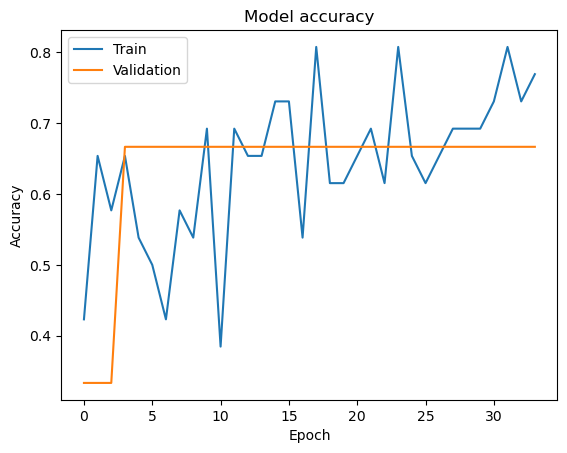

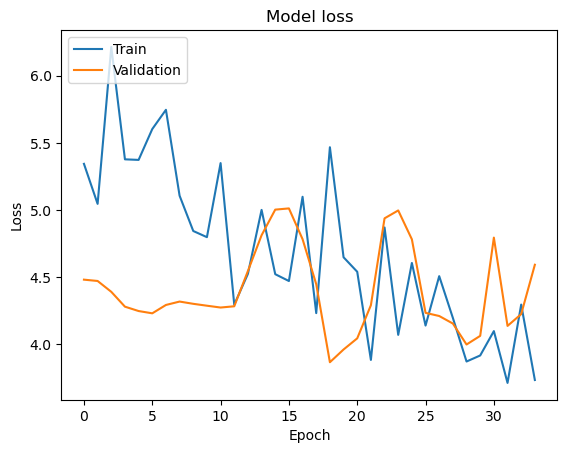

In [98]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()